Run the kSZ 4-point estimator on the Amber simulations

In [1]:
from os.path import join as opj
import os
os.environ["DISABLE_MPI"]="true"
from ksz4.cross import four_split_K, split_phi_to_cl, mcrdn0_s4
from ksz4.reconstruction import setup_recon, setup_ABCD_recon, get_cl_fg_smooth
from pixell import curvedsky, enmap
from scipy.signal import savgol_filter
from cmbsky import safe_mkdir, get_disable_mpi, ClBinner
from falafel import utils, qe
import healpy as hp
import yaml
import argparse
from orphics import maps, mpi
import numpy as np
import pickle
from string import Template
from pytempura import noise_spec
import glob
import matplotlib.pyplot as plt

/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/cmbsky-0.0.1-py3.8.egg/cmbsky/utils.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEFAULTS=yaml.load(f)


- First thing I'm going to do is convert the maps to alms so we don't have to do that every time (comment out save_alms below)

In [2]:
sim_dir = "/global/cfs/cdirs/cmb/data/generic/extragalactic/amber/"
output_alm_dir = "/global/cfs/projectdirs/act/data/maccrann/amber"

sim_map_files = glob.glob(opj(sim_dir, "output*", "cmb", "map_ksz_nside=4096.fits"))
sim_tags = [f.split("/")[-3] for f in sim_map_files]
lmax_alm=8000
sim_alm_files = [opj(output_alm_dir, sim_tag+"ksz_alm_lmax%d.fits"%(lmax_alm)) for sim_tag in sim_tags]
print(sim_alm_files[0])

/global/cfs/projectdirs/act/data/maccrann/amber/output_z=8.00_D=4.00_A=3.00_M=1E8_l=3.00ksz_alm_lmax8000.fits


In [3]:
def save_alms():
    safe_mkdir(output_alm_dir)
    for f_map,f_alm in zip(sim_map_files, sim_alm_files):
        print(f_map)
        m = hp.read_map(f_map)
        alm = hp.map2alm(m, lmax=lmax_alm)
        hp.write_alm(f_alm, alm)

#Uncomment the below if this is the first time running!!!
#save_alms()
#do_stuff

- First thing to decide is the filters to use. We generally want to use Cl_KSZ^0.5 / Cl_total
- Probably less confusing to use the same filters for all the different simulations, so start by 
using the Alvarez Cl_KSZ.

In [4]:
cl_ksz_raw=np.load("../tests/cl_4e3_2048_50_50_ksz.npy")
cl_ksz = savgol_filter(cl_ksz_raw, 301, 2)
#cl_ksz_raw = hp.alm2cl( hp.read_alm(sim_alm_files[0]) )
#smooth this
#cl_ksz = savgol_filter(cl_ksz_raw, 301, 2)
#negative values in this causes nans, so I'm going to 
#set low ls to some constant - we don't use these anyway
#cl_ksz[:1000] = cl_ksz[1000]

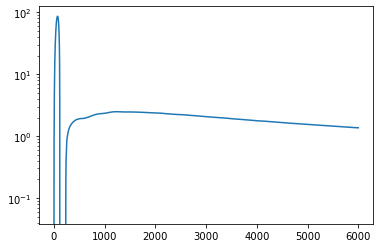

In [5]:
%matplotlib inline

ls = np.arange(len(cl_ksz))
lfac=ls*(ls+1)/2/np.pi

fig,ax=plt.subplots()
ax.plot(ls, lfac*cl_ksz)
ax.set_yscale('log')

Few more options to set here:
- Noise level (let's assume white noise)
- lmin and lmax 
- Think that's it really
- oh and beam

In [6]:
noise_sigma = 10.  #muK arcmin
beam_fwhm = 1.5 #arcmin
lmin = 3000
lmax = 4000
mlmax = 5000
px=qe.pixelization(nside=4096)

- Get beam, noise and total Cl

In [7]:
ells = np.arange(mlmax+1)
beam = maps.gauss_beam(ells, beam_fwhm)
Nl_tt = (noise_sigma*np.pi/180./60.)**2./beam**2
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}
_,tcls = utils.get_theory_dicts(grad=True, nells=nells, lmax=mlmax)
Cl_tot_theory = tcls["TT"][:mlmax+1] + cl_ksz[:mlmax+1] #add kSZ to total Cl

#Could also use total Cl from data...
#with open("/pscratch/sd/m/maccrann/ksz_outputs/test_hilc_hilc-tszandcibd_hilc_hilc_dr6lens_ilc-rerun_lmax4000_w217_v12.10.23_wpb_fullsimrdn0/auto_outputs.pkl","rb") as f:
#    auto_outputs = pickle.load(f)
#Cl_tot = auto_outputs["cltot_A"]
Cl_tot = Cl_tot_theory


In [9]:
#setup the estimators etc.
#I'm using the most general setup here (which allows for 4 different maps).
#But here we're just using the same map in each leg hence all those Cl_tot
#arguments are the same. 
recon_setup = setup_ABCD_recon(px, lmin, lmax, mlmax,
                      cl_ksz[:mlmax+1], Cl_tot, Cl_tot,
                      Cl_tot, Cl_tot,
                      Cl_tot, Cl_tot,
                      Cl_tot, Cl_tot, do_lh=True,
                      do_psh=False)

/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/ksz4-0.0.1-py3.8.egg/ksz4/reconstruction.py:228: RuntimeWarning: invalid value encountered in sqrt


getting qe N0s
 Response (TT,asym)
 Response (TT,asym)
 Response (TT,asym)
 Response (TT,asym)
getting qe fg_trispectrum functions
getting AB and CD qfuncs for qe


recon_setup is a dictionary that contains various things (including the "qfuncs") we need to run the estimator on the data, and als
funtions for getting theory N0s. So now we're ready to read in maps and run on them.

In [ ]:
CL_KK_stuff = {}

n_sim_to_run = 2 #just going to run the first two sims for now
for sim_tag, alm_file in zip(sim_tags[:n_sim_to_run], sim_alm_files):
    print(sim_tag)
    CL_KK_stuff[sim_tag] = {}
    #read in map, convert to alms, and filter
    alm = hp.read_alm(alm_file)
    alm_Af = recon_setup["filter_A"](alm) #note only need to use filter_A since all legs the same here
    
    K = recon_setup["qfunc_K_AB"](alm_Af, alm_Af)
    CL_KK_stuff[sim_tag]["CL_KK_raw"] = curvedsky.alm2cl(K,K)

    #Also need N0. setup_recon has a function to calculate this, but needs the power of the simulation
    cl_sim_raw = curvedsky.alm2cl(alm) 
    #again, smooth this. probably unnecessary?
    cl_sim = savgol_filter(cl_sim_raw, 301, 2)
    
    trispectrum_N0 = recon_setup["get_fg_trispectrum_N0_ABCD"](cl_sim, cl_sim, cl_sim, cl_sim)
    CL_KK_stuff[sim_tag]["N0"] = trispectrum_N0
    CL_KK_stuff[sim_tag]["CL_KK"] = CL_KK_stuff[sim_tag]["CL_KK_raw"] - CL_KK_stuff[sim_tag]["N0"]
    

output_z=8.00_D=4.00_A=3.00_M=1E8_l=3.00
mlmax: 8000
lmin: 3000
lmax: 4000
(5001,)
output_z=8.00_D=4.00_A=3.00_M=1E8_l=5.00
mlmax: 8000
lmin: 3000
lmax: 4000


In [ ]:
import pickle
with open("amber_auto_data_test.pkl", "wb") as f:
    pickle.dump(CL_KK_stuff, f)

In [ ]:
#print(binner.bin_mids)
print( CL_KK_stuff["output_z=8.00_D=4.00_A=3.00_M=1E8_l=5.00"]["CL_KK_raw"] )

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

binner = ClBinner(lmin=5, lmax=200, nbin=10, log=True)
sim_tag = "output_z=8.00_D=4.00_A=3.00_M=1E8_l=5.00"
profile = recon_setup["profile"]
for sim_tag in sim_tags[:n_sim_to_run]:
    CL_KK = (CL_KK_stuff[sim_tag]["CL_KK_raw"] - CL_KK_stuff[sim_tag]["N0"])/profile**2
    ax.plot(binner.bin_mids, binner.bin_mids**2*binner(CL_KK),
           label=sim_tag)
    #ax.plot(binner.bin_mids, binner.bin_mids**2*binner(CL_KK_stuff[sim_tag]["CL_KK_raw"]), 
    #       label=sim_tag)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()